In [1]:
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
from tqdm import tqdm
import time
import random
import os
from glob import glob
from PIL import Image
from PIL import Image, ImageDraw
import cv2
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torchvision.transforms as transforms
from torchvision import utils
import torch.optim as optim
from torch.optim import Adam
import torch.nn.init as init
import torchvision.transforms.functional as TF

import pydicom as dicom
import nibabel as nib
from nibabel.testing import data_path
import tempfile
import seaborn as sns
from skimage.transform import rotate

## Import and Read Datasets

In [2]:
# Target labels for the train set
train_target_label_df = pd.read_csv('train.csv') 

# Each patient may have been scanned once or twice. Each scan contains a series of images.
train_series_meta_df = pd.read_csv('train_series_meta.csv')
test_series_meta_df = pd.read_csv('test_series_meta.csv')

# Train only. Identifies specific images that contain either bowel or extravasation injuries.
image_level_labels_df = pd.read_csv('image_level_labels.csv')

# A valid sample submission. Only the first few rows are available for download.
sample_submission_df = pd.read_csv('sample_submission.csv')

In [3]:
# Target labels for the train set
print(train_target_label_df.shape)
train_target_label_df.head()

(3147, 15)


,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1
1,10005,1,0,1,0,1,0,0,1,0,0,1,0,0,0
2,10007,1,0,1,0,1,0,0,1,0,0,1,0,0,0
3,10026,1,0,1,0,1,0,0,1,0,0,1,0,0,0
4,10051,1,0,1,0,1,0,0,1,0,0,0,1,0,1


In [4]:
# Train: Each patient may have been scanned once or twice. Each scan contains a series of images.
print(train_series_meta_df.shape)
train_series_meta_df.head()

(4711, 4)


,patient_id,series_id,aortic_hu,incomplete_organ
0,10004,21057,146.00,0
1,10004,51033,454.75,0
2,10005,18667,187.00,0
3,10007,47578,329.00,0
4,10026,29700,327.00,0


In [5]:
# Test: Each patient may have been scanned once or twice. Each scan contains a series of images.
print(test_series_meta_df.shape)
test_series_meta_df.head() 

(6, 3)


,patient_id,series_id,aortic_hu
0,48843,295,401.25
1,48843,62825,238.00
2,50046,24574,149.00
3,50046,60658,352.00
4,63706,39279,219.00


In [6]:
# Train only. Identifies specific images that contain either bowel or extravasation injuries.
print(image_level_labels_df.shape)
image_level_labels_df.head()

(12029, 4)


,patient_id,series_id,instance_number,injury_name
0,10004,21057,362,Active_Extravasation
1,10004,21057,363,Active_Extravasation
2,10004,21057,364,Active_Extravasation
3,10004,21057,365,Active_Extravasation
4,10004,21057,366,Active_Extravasation


In [7]:
# Check the values in injury_name
image_level_labels_df['injury_name'].unique()

array(['Active_Extravasation', 'Bowel'], dtype=object)

In [8]:
# A valid sample submission. Only the first few rows are available for download.
print(sample_submission_df.shape)
sample_submission_df.head()

(3, 14)


,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high
0,48843,0.5,0.5,0.5,0.5,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333
1,50046,0.5,0.5,0.5,0.5,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333
2,63706,0.5,0.5,0.5,0.5,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333


In [9]:
# Reading parquet data

# DICOM tags from every image, extracted with Pydicom.
train_dicom_tags_parquet = pq.read_table('train_dicom_tags.parquet')
test_dicom_tags_parquet = pq.read_table('test_dicom_tags.parquet')

In [10]:
print(train_dicom_tags_parquet.shape)
print(test_dicom_tags_parquet.shape)

(1510373, 35)
(3, 35)


In [11]:
# Convert the pyarrow table dataset into a pandas dataframe
train_dicom_tags_parquet_df = train_dicom_tags_parquet.to_pandas()
test_dicom_tags_parquet_df = test_dicom_tags_parquet.to_pandas()

In [12]:
# Train: Taking transpose to print dataset
train_dicom_tags_parquet_df.head().T

,0,1,2,3,4
BitsAllocated,16,16,16,16,16
BitsStored,16,16,16,16,16
Columns,512,512,512,512,512
ContentDate,20230722,20230722,20230722,20230722,20230722
ContentTime,003306.881589,003303.279137,003343.090736,003252.960345,003155.059398
FrameOfReferenceUID,1.2.826.0.1.3680043.8.498.28466454913303094199...,1.2.826.0.1.3680043.8.498.28466454913303094199...,1.2.826.0.1.3680043.8.498.28466454913303094199...,1.2.826.0.1.3680043.8.498.28466454913303094199...,1.2.826.0.1.3680043.8.498.28466454913303094199...
HighBit,15,15,15,15,15
ImageOrientationPatient,"[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...","[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...","[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...","[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...","[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ..."
ImagePositionPatient,"[-235.8665, -235.8665, 1459.20]","[-235.8665, -235.8665, 1474.40]","[-235.8665, -235.8665, 1310.40]","[-235.8665, -235.8665, 1520.00]","[-235.8665, -235.8665, 1756.00]"
InstanceNumber,532,513,718,456,161


In [13]:
# Test：Taking transpose to print dataset
test_dicom_tags_parquet_df.head().T

,0,1,2
BitsAllocated,16,16,16
BitsStored,12,16,12
Columns,512,512,512
ContentDate,20230722,20230722,20230722
ContentTime,002246.191887,003830.929278,005441.112500
FrameOfReferenceUID,1.2.826.0.1.3680043.8.498.92271913265819460212...,1.2.826.0.1.3680043.8.498.70045142309401550406...,1.2.826.0.1.3680043.8.498.64877973120200061370...
HighBit,11,15,11
ImageOrientationPatient,"[1, 0, 0, 0, 1, 0]","[1.000000, 0.000000, 0.000000, 0.000000, 1.000...","[1, 0, 0, 0, 1, 0]"
ImagePositionPatient,"[-225.609375, -299.609375, -1099]","[-214.26, -203.431, -172.802]","[-179.1416015625, -343.1416015625, -477]"
InstanceNumber,30,30,30


## Exploratory Data Analysis

### Target labels for the train set

In [14]:
# Check duplicated values
train_target_label_df.duplicated().sum()

0

In [15]:
# stats of variables
train_target_label_df.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_id,3147.0,32664.239593,18792.043458,19.0,16355.5,32195.0,49302.5,65508.0
bowel_healthy,3147.0,0.979663,0.141172,0.0,1.0,1.0,1.0,1.0
bowel_injury,3147.0,0.020337,0.141172,0.0,0.0,0.0,0.0,1.0
extravasation_healthy,3147.0,0.936447,0.243993,0.0,1.0,1.0,1.0,1.0
extravasation_injury,3147.0,0.063553,0.243993,0.0,0.0,0.0,0.0,1.0
kidney_healthy,3147.0,0.942167,0.233464,0.0,1.0,1.0,1.0,1.0
kidney_low,3147.0,0.036543,0.187666,0.0,0.0,0.0,0.0,1.0
kidney_high,3147.0,0.021290,0.144373,0.0,0.0,0.0,0.0,1.0
liver_healthy,3147.0,0.897998,0.302699,0.0,1.0,1.0,1.0,1.0
liver_low,3147.0,0.082301,0.274866,0.0,0.0,0.0,0.0,1.0


### Train Series Metadata: train_series_meta_df

In [16]:
# Check duplicated values
train_series_meta_df.duplicated().sum()

0

In [17]:
# stats of variables
train_series_meta_df.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_id,4711.0,32722.826788,18745.299924,19.0,16436.0,32235.0,49267.5,65508.0
series_id,4711.0,32661.752494,18800.490133,3.0,16298.5,32387.0,48861.5,65535.0
aortic_hu,4711.0,223.622373,103.767762,-1024.0,147.0,194.0,280.0,1411.0
incomplete_organ,4711.0,0.066440,0.249077,0.0,0.0,0.0,0.0,1.0


In [18]:
# Calculate the percentage of patient who has imcomplete organs
complete_organ_count = train_series_meta_df['incomplete_organ'].value_counts()[0]
incomplete_organ_count = train_series_meta_df['incomplete_organ'].value_counts()[1]
total = complete_organ_count + incomplete_organ_count

print("complete organ percentage:", '%.2f' % (complete_organ_count/total*100))
print("incomplete organ percentage:", '%.2f' % (incomplete_organ_count/total*100))

complete organ percentage: 93.36
incomplete organ percentage: 6.64


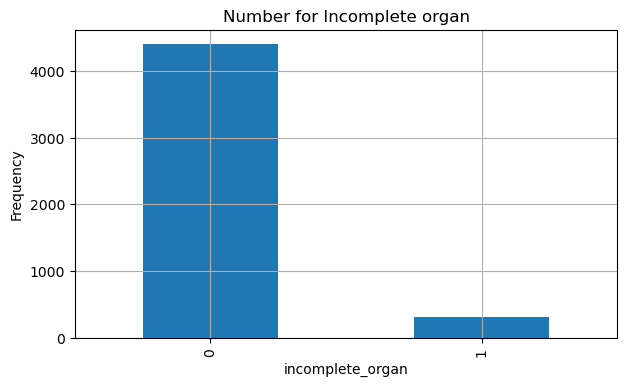

In [19]:
# Distribution of "incomplete organ"
train_meta_plot = train_series_meta_df['incomplete_organ'].value_counts().plot(kind='bar',
                                    figsize=(7,4), grid=True,
                                    title="Number for Incomplete organ")
train_meta_plot.set_xlabel("incomplete_organ")
train_meta_plot.set_ylabel("Frequency");

###  Test Series Metadata: test_series_meta_df

In [20]:
# Check duplicated values
test_series_meta_df.duplicated().sum()

0

In [21]:
# stats of variables
test_series_meta_df.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_id,6.0,54198.333333,7384.231650,48843.0,49143.75,50046.0,60291.00,63706.00
series_id,6.0,38169.333333,23428.666686,295.0,28250.25,40332.0,55839.75,62825.00
aortic_hu,6.0,279.708333,93.863787,149.0,223.75,278.5,343.75,401.25


### Bowel or Extravasation Injuries: image_level_labels_df

In [22]:
# Check duplicated values
image_level_labels_df.duplicated().sum()

0

In [23]:
# stats of variables
image_level_labels_df.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_id,12029.0,34909.677862,19532.614584,33.0,15876.0,36289.0,53908.0,65456.0
series_id,12029.0,31188.356056,19532.946255,242.0,14738.0,28751.0,49108.0,65514.0
instance_number,12029.0,311.704132,210.025487,11.0,130.0,252.0,456.0,1065.0


In [24]:
image_level_labels_df['injury_name'].unique()

array(['Active_Extravasation', 'Bowel'], dtype=object)

In [25]:
image_level_labels_df.head()

,patient_id,series_id,instance_number,injury_name
0,10004,21057,362,Active_Extravasation
1,10004,21057,363,Active_Extravasation
2,10004,21057,364,Active_Extravasation
3,10004,21057,365,Active_Extravasation
4,10004,21057,366,Active_Extravasation


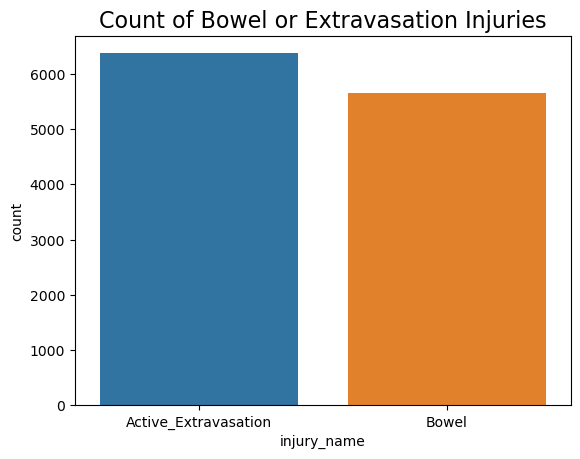

In [26]:
# Distribution of "incomplete organ"
sns.countplot(x='injury_name',data=image_level_labels_df)
plt.title('Count of Bowel or Extravasation Injuries',fontsize=16)
plt.show();

In [27]:
# Calculate the percentages of Bowel or Extravasation Injuries
active_extravasation_count = image_level_labels_df['injury_name'].value_counts()[0]
bowel_count = image_level_labels_df['injury_name'].value_counts()[1]
total2 = active_extravasation_count + bowel_count

print("Active_Extravasation percentage (%):", '%.2f' % (active_extravasation_count/total2*100))
print("Bowel percentage (%):", '%.2f' % (bowel_count/total2*100))

Active_Extravasation percentage (%): 52.96
Bowel percentage (%): 47.04


## Merge Datasets

In [28]:
# Merge train_target_label_df and train_series_meta_df on patient id
train_target_series_id = pd.merge(train_target_label_df, train_series_meta_df, on='patient_id')
train_target_series_id.head()

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury,series_id,aortic_hu,incomplete_organ
0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,146.00,0
1,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,51033,454.75,0
2,10005,1,0,1,0,1,0,0,1,0,0,1,0,0,0,18667,187.00,0
3,10007,1,0,1,0,1,0,0,1,0,0,1,0,0,0,47578,329.00,0
4,10026,1,0,1,0,1,0,0,1,0,0,1,0,0,0,29700,327.00,0


In [29]:
# We looked at the ct images for pt_id 156, and we would like to know if they have any injuries
train_target_series_id.loc[train_target_series_id['patient_id'] == 156]

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury,series_id,aortic_hu,incomplete_organ
457,156,1,0,1,0,1,0,0,1,0,0,1,0,0,0,64005,206.0,0


In [30]:
# Count of bowel and extravasation healthy
bowel_healthy_count = train_target_series_id["bowel_healthy"].sum()
bowel_injury_count = train_target_series_id["bowel_injury"].sum()
extravasation_healthy_count = train_target_series_id["extravasation_healthy"].sum()
extravasation_injury_count = train_target_series_id["extravasation_injury"].sum()
bowel_extravasation = {'bowel_healthy': [bowel_injury_count, bowel_healthy_count],
                      'extravasation_healthy': [extravasation_injury_count, extravasation_healthy_count]}
bowel_extravasation = pd.DataFrame(data=bowel_extravasation)
bowel_extravasation

,bowel_healthy,extravasation_healthy
0,104,300
1,4607,4411


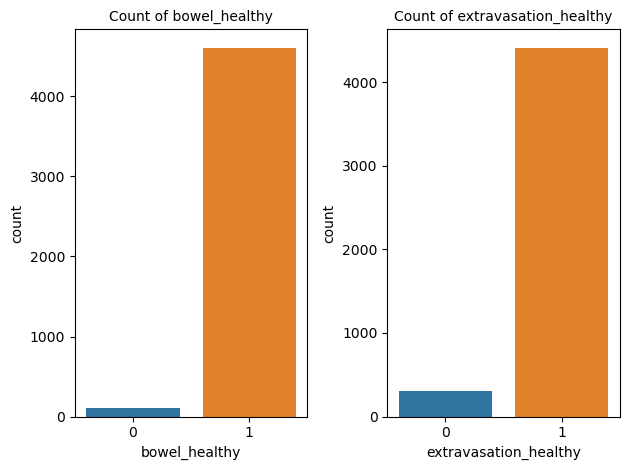

In [31]:
# Distribution of "bowel_healthy"
plt.subplot(1, 2, 1)
sns.countplot(x='bowel_healthy',data=train_target_series_id)
plt.title('Count of bowel_healthy',fontsize=10)

# Distribution of "extravasation_healthy"
plt.subplot(1, 2, 2) 
sns.countplot(x='extravasation_healthy',data=train_target_series_id)
plt.title('Count of extravasation_healthy',fontsize=10)
plt.tight_layout()
plt.show();

In [32]:
# Count of kidney, liver and spleen(healthy, low, high)
kidney_healthy_count = train_target_series_id["kidney_healthy"].sum()
kidney_low_count = train_target_series_id["kidney_low"].sum()
kidney_high_count = train_target_series_id["kidney_high"].sum()
liver_healthy_count = train_target_series_id["liver_healthy"].sum()
liver_low_count = train_target_series_id["liver_low"].sum()
liver_high_count = train_target_series_id["liver_high"].sum()
spleen_healthy_count = train_target_series_id["spleen_healthy"].sum()
spleen_low_count = train_target_series_id["spleen_low"].sum()
spleen_high_count = train_target_series_id["spleen_high"].sum()

organs_count = {'kidney': [kidney_healthy_count, kidney_low_count, kidney_high_count],
                'liver': [liver_healthy_count, liver_low_count, liver_high_count],
                'spleen': [spleen_healthy_count, spleen_low_count, spleen_high_count]}
organs_count = pd.DataFrame(data=organs_count)
organs_count

,kidney,liver,spleen
0,4426,4236,4166
1,176,384,316
2,109,91,229


### Display CT images

In [33]:
train_images = glob('../rsna-2023-abdominal-trauma-detection/train_images/156/64005/*')

IndexError: list index out of range

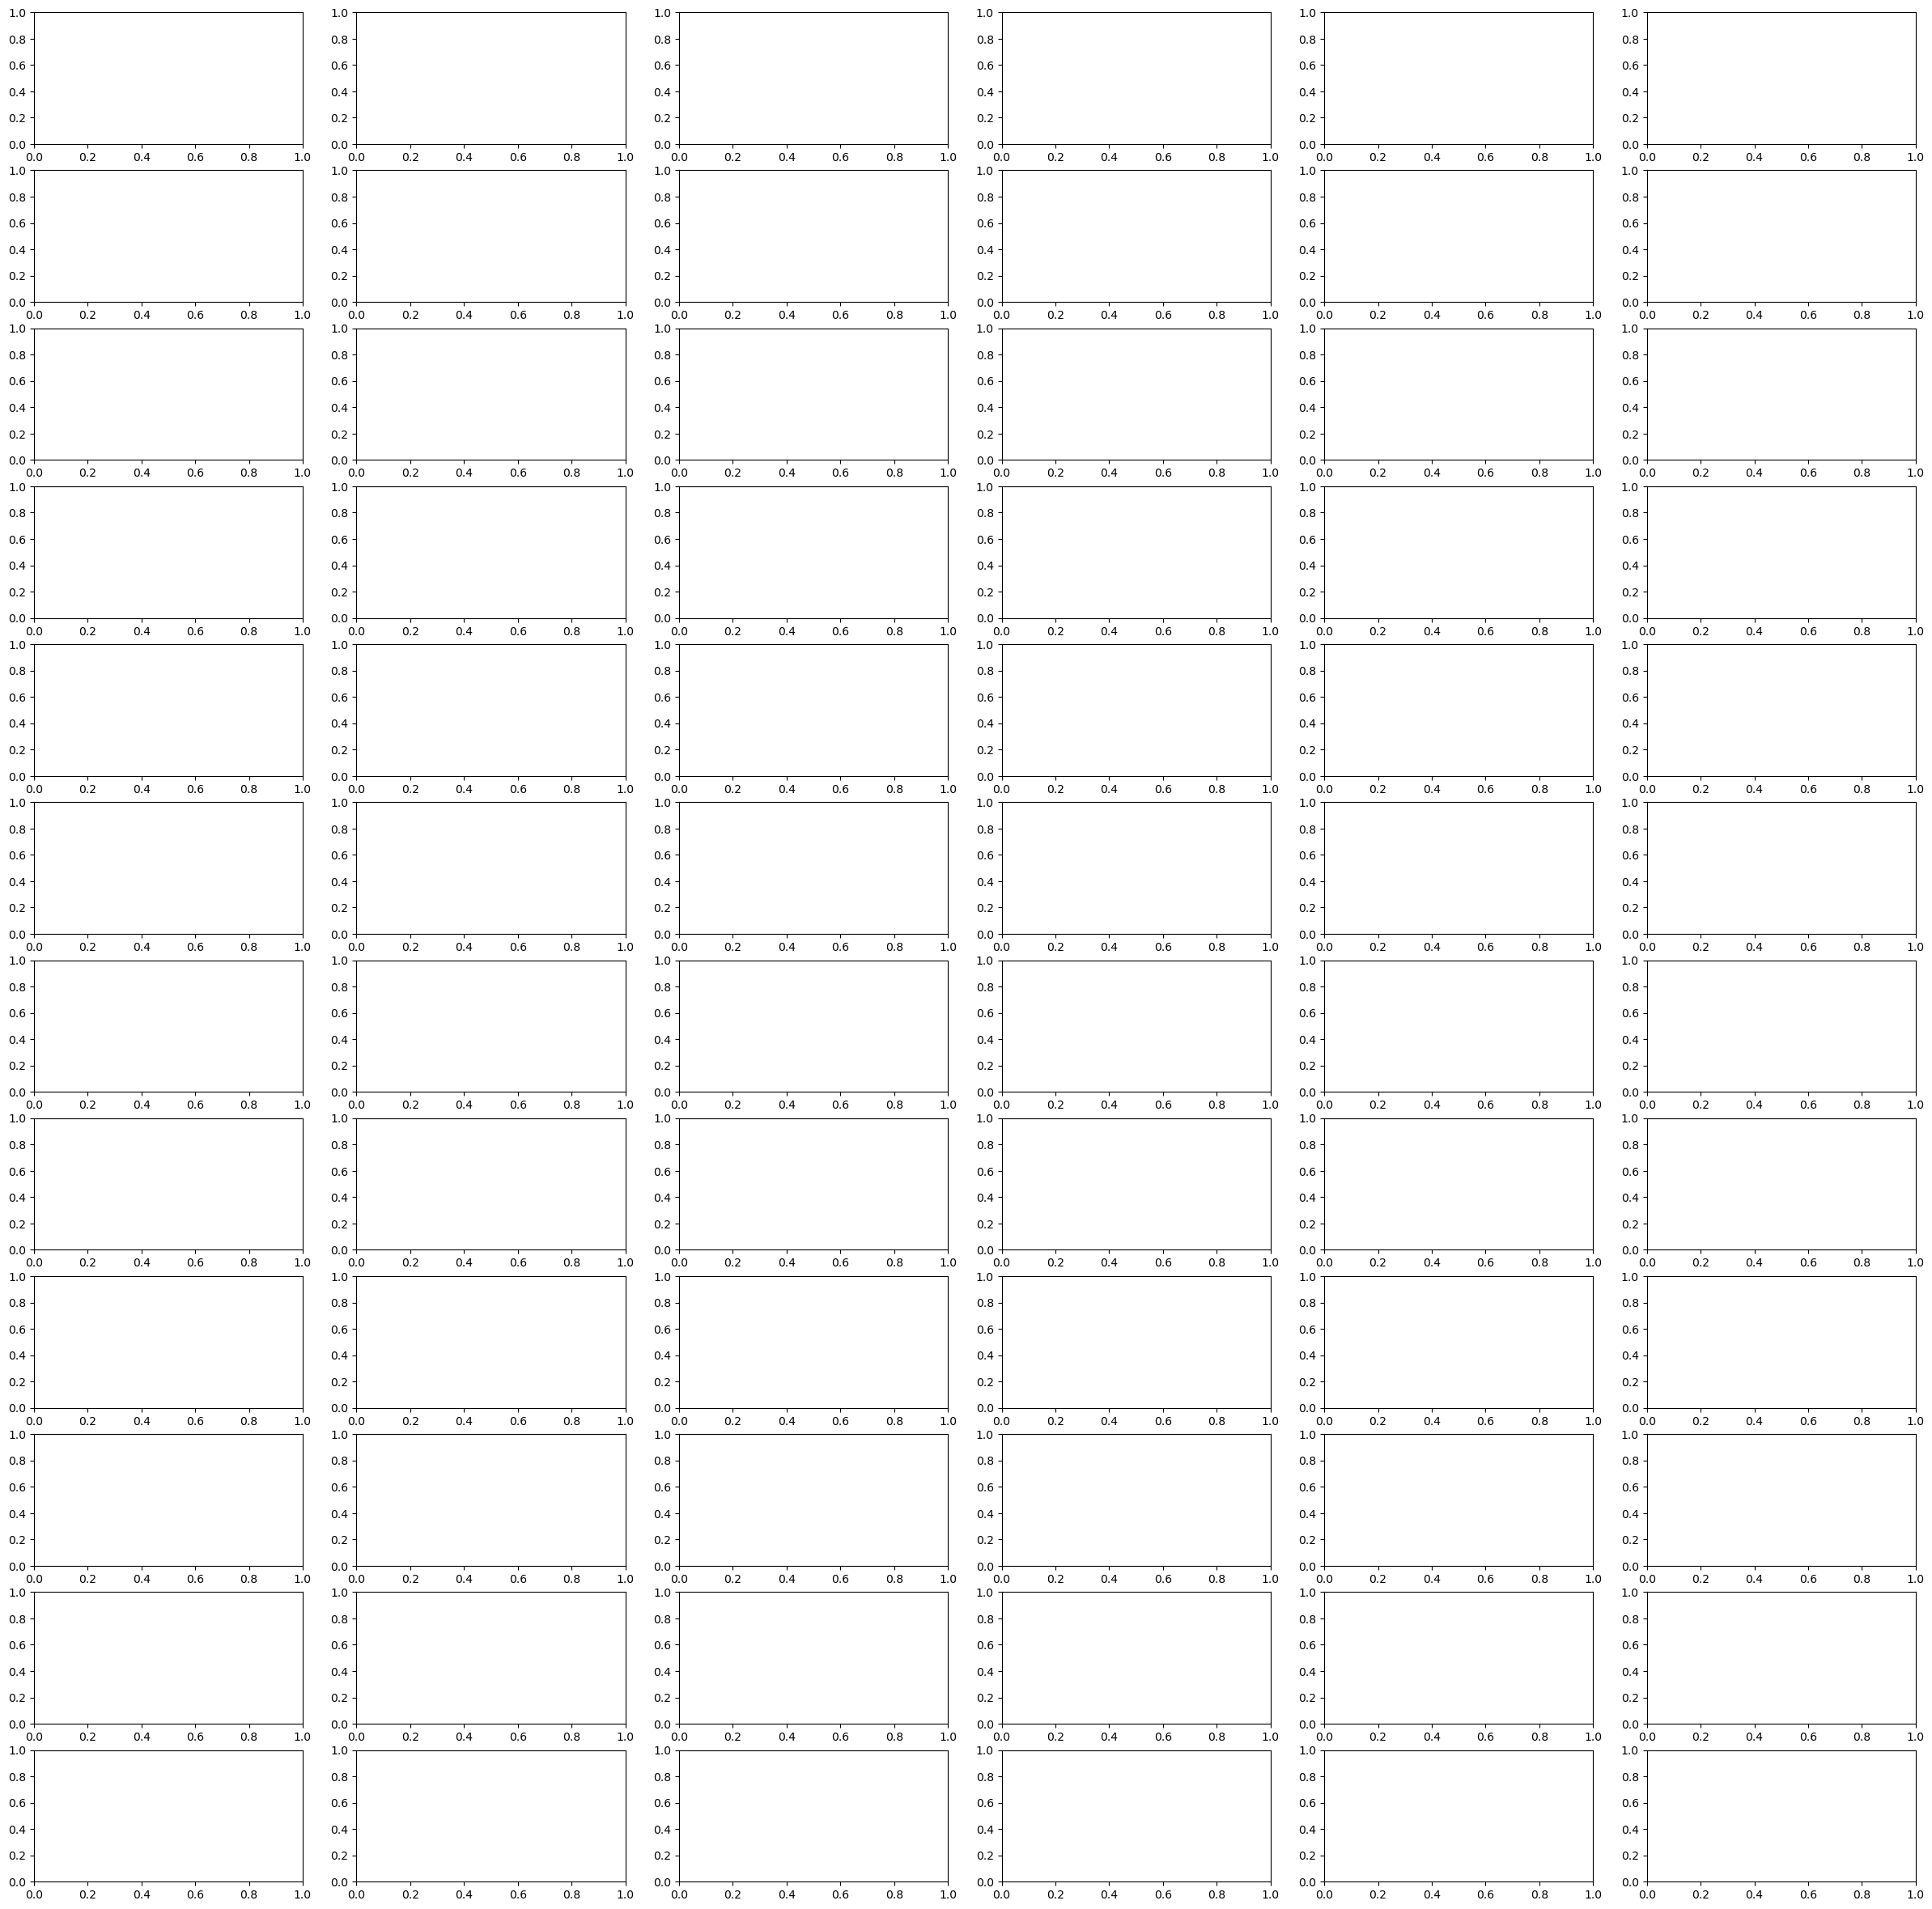

In [34]:
fig, axes = plt.subplots(12, 6, figsize=(30, 30))
train_images
for i, ax in enumerate(axes.reshape(-1)):
    img_path = train_images[i]
    img = dicom.dcmread(img_path)  
    ax.imshow(img.pixel_array)
plt.show()

In [ ]:
# Display nii 397
path = '../rsna-2023-abdominal-trauma-detection/segmentations/397.nii'

In [ ]:
img = nib.load(path).get_fdata()
img.shape

In [ ]:
print(f"The .nii files are stored in memory as numpy's: {type(img)}.")

In [ ]:
fig, axes = plt.subplots(6,6, figsize=(12,12))
for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(img[:,:,1 + i])
plt.show()

In [ ]:
fig, axes = plt.subplots(4,4, figsize=(12,12))
for i, ax in enumerate(axes.reshape(-1)):
    img_rot = rotate(img[:,:,1 + i], 90)
    img_flip = cv2.flip(img_rot, 1)
    ax.imshow(img_flip)
plt.show()